In [2]:
import os
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from netrd.distance import DeltaCon


import pystablemotifs as sm
from pyboolnet.file_exchange import bnet2primes
import pystablemotifs.export as ex
import networkx as nx

In [11]:
model_path = '/home/spankaew/Git/astrologics/models/herault_hematopoiesis/'
model_files = os.listdir(model_path)

# Setup the simulation size
max_simulate_size = 30

# Create a dictionary object to store models
models_net = {}

# Loop through the models
for i in tqdm(model_files): 
    # Adjust model name
    model_name = i.replace('.bnet','')
    primes = bnet2primes(model_path + i)
    ar = sm.AttractorRepertoire.from_primes(primes, max_simulate_size=max_simulate_size)
    models_net[model_name]=ex.networkx_succession_diagram(ar,include_attractors_in_diagram=True)

# Get the lits of nodes names
node_name = list(primes.keys())

100%|██████████| 616/616 [05:11<00:00,  1.97it/s]


In [12]:
states_mtx = pd.DataFrame()
states_bin = pd.DataFrame()
for i in tqdm(list(models_net.keys())):
    # Extract states from GM nodes
    indexes = [data['index'] for _, data in models_net[i].nodes(data=True) if 'index' in data]
    indexes = ['A' if isinstance(i, str) else i for i in indexes]
    
    labels = [data['label'] for _, data in models_net[i].nodes(data=True) if 'label' in data]
    states = [data['states'] for _, data in models_net[i].nodes(data=True) if 'states' in data]

    # Create a new label index
    new_index = []
    for idx, index in enumerate(indexes):
        if isinstance(index, int):
            new_index.append(labels[idx])
        elif isinstance(index, str):
            new_index.append(index)
    new_index

    # Convert to DataFrame
    states_df = pd.DataFrame(states)
    # Convert values to int or logical value
    states_df = states_df.map(lambda x: int(x) if pd.notnull(x) else '*')

    # Set index to the matrix 
    states_df = states_df[node_name]
    states_df_strings = states_df.apply(lambda row: ''.join(row.astype(str)), axis=1)
    new_index = [new_index[j]+'_'+states_df_strings[j] for j in range(len(states_df_strings))]

    states_df.index = new_index

    # Fill NA with *
    states_df.fillna('*',inplace=True)

    # Concatenate the matrix
    states_mtx = pd.concat([states_mtx, states_df], axis=0, ignore_index = False)
    states_mtx = states_mtx[~states_mtx.index.duplicated(keep='first')]

    # Count the index from each of the models
    states_bin = pd.concat([states_bin, states_df.index.value_counts()], axis=1, ignore_index = False)
    states_bin.fillna(0, inplace=True)

states_bin.columns = list(models_net.keys())
all_states = list(states_bin.index)

  0%|          | 0/616 [00:00<?, ?it/s]

100%|██████████| 616/616 [00:03<00:00, 167.17it/s]


/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


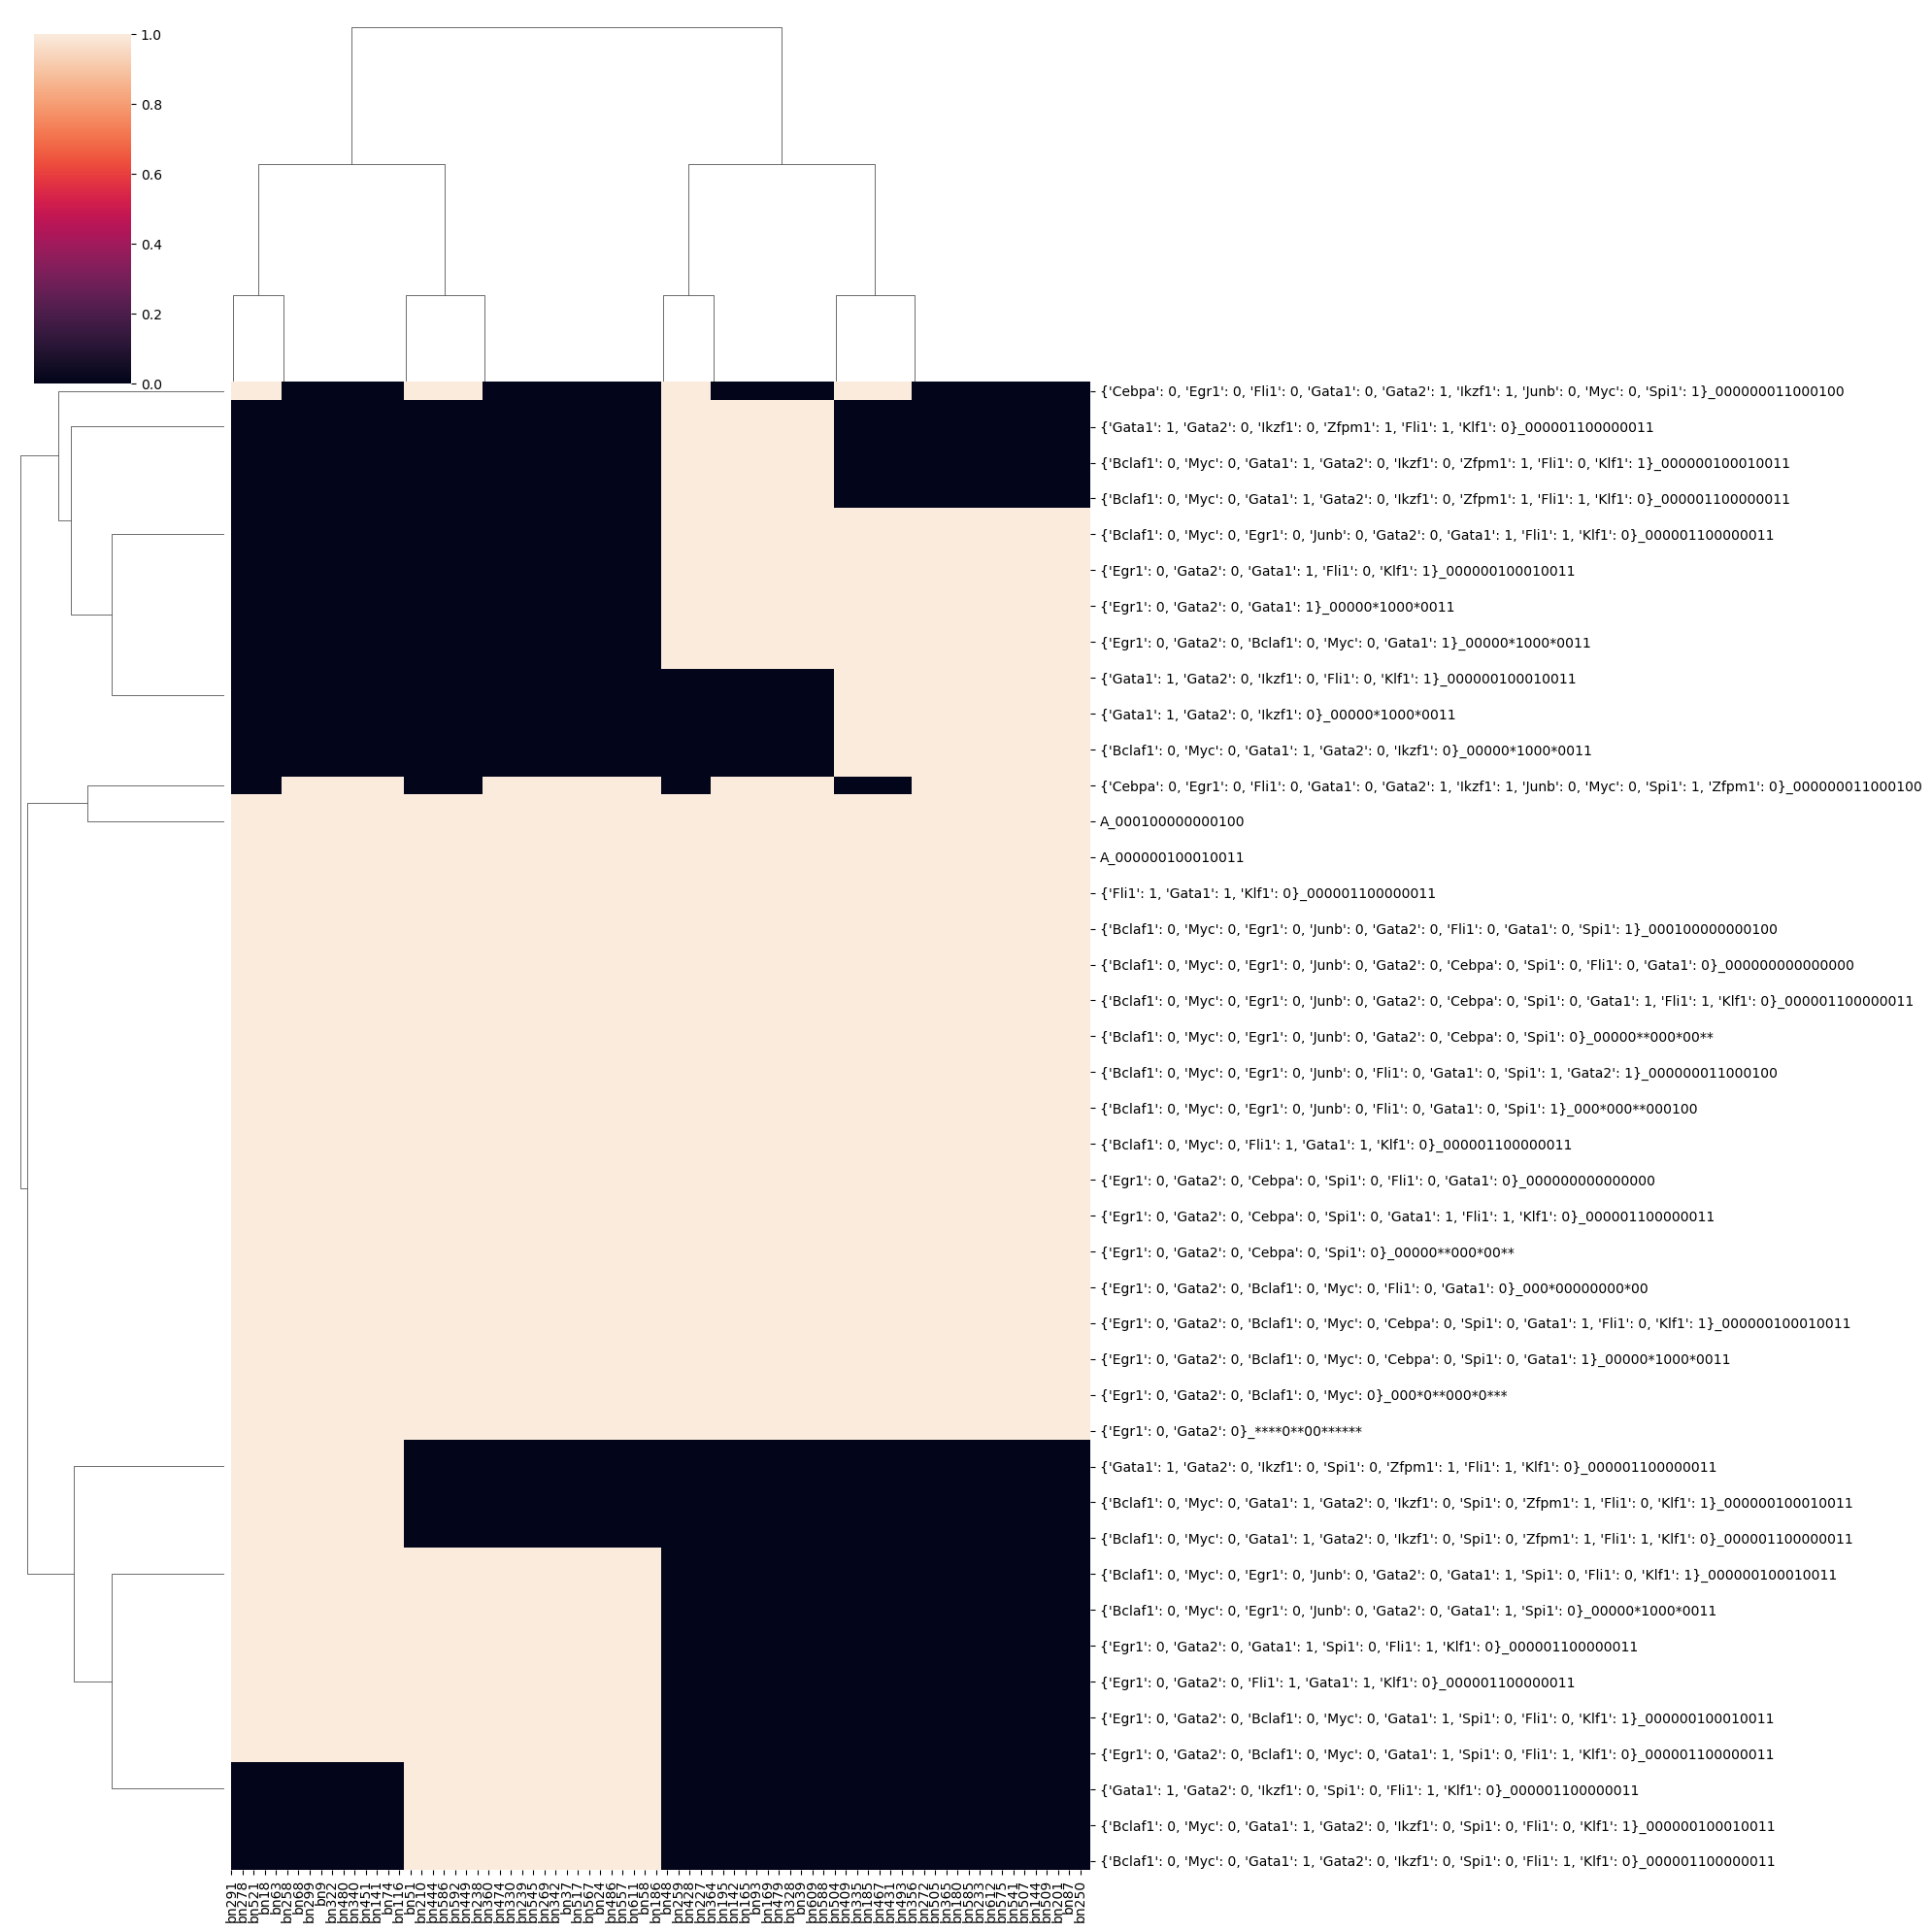

In [13]:
import seaborn as sns
sns.clustermap(states_bin, figsize=(20, 20))

In [ ]:
model_adj = {}

for i in tqdm(list(models_net.keys())):

    # Extract states from GM nodes
    indexes = [data['index'] for _, data in models_net[i].nodes(data=True) if 'index' in data]
    indexes = ['A' if isinstance(i, str) else i for i in indexes]

    labels = [data['label'] for _, data in models_net[i].nodes(data=True) if 'label' in data]
    states = [data['states'] for _, data in models_net[i].nodes(data=True) if 'states' in data]


    # Create a new label index
    new_index = []
    for idx, index in enumerate(indexes):
        if isinstance(index, int):
            new_index.append(labels[idx])
        elif isinstance(index, str):
            new_index.append(index)
    new_index

    # Convert to DataFrame
    states_df = pd.DataFrame(states)
    # Convert values to int or logical value
    states_df = states_df.map(lambda x: int(x) if pd.notnull(x) else '*')

    # Set index to the matrix 
    states_df = states_df[node_name]
    states_df_strings = states_df.apply(lambda row: ''.join(row.astype(str)), axis=1)
    new_index = [new_index[j]+'_'+states_df_strings[j] for j in range(len(states_df_strings))]

    # Create a matrix of the states
    model_adj[i] = nx.to_pandas_adjacency(models_net[i])
    model_adj[i].index = new_index
    model_adj[i].columns = new_index

    # Reindex the matrix according to the states_bin
    model_adj[i] = model_adj[i].reindex(all_states, axis=0).reindex(all_states, axis=1)
    model_adj[i].fillna(0, inplace=True)

# Create a networks objects
N = len(model_adj.keys())
model_list = list(model_adj.keys())

networks = []
# Compute the distance matrix
for i in tqdm(model_list):
    G = nx.from_numpy_array(model_adj[i].to_numpy(), create_using=nx.DiGraph)
    networks.append(G)

  2%|▏         | 10/616 [00:00<00:06, 93.98it/s]

100%|██████████| 616/616 [00:00<00:00, 1452.22it/s]


In [15]:
from netrd.distance import DeltaCon
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

# Compute DeltaCon distance matrix
N = len(networks)
distance_matrix = np.zeros((N, N))
deltacon = DeltaCon()

for i in tqdm(range(N)):
    for j in range(i+1, N):
        dist = deltacon.dist(networks[i], networks[j])
        distance_matrix[i, j] = dist
        distance_matrix[j, i] = dist

distance_matrix = pd.DataFrame(distance_matrix, index=model_list, columns=model_list)

  0%|          | 0/616 [00:00<?, ?it/s]/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/netrd/utilities/graph.py:74: RuntimeWarning: Coercing directed graph to undirected.
  warnings.warn("Coercing directed graph to undirected.", RuntimeWarning)
100%|██████████| 616/616 [09:19<00:00,  1.10it/s]


In [59]:
distance_matrix

,bn168,bn602,bn157,bn45,bn8,bn109,bn307,bn12,bn530,bn321,bn547,bn487,bn408,bn404,bn566,bn494,bn580,bn65,bn122,bn421,bn170,bn42,bn351,bn553,bn186,bn326,bn238,bn131,bn212,bn499,bn369,bn383,bn250,bn572,bn341,bn60,bn215,bn391,bn206,bn116,bn224,bn465,bn100,bn271,bn571,bn542,bn442,bn534,bn70,bn588,bn434,bn28,bn436,bn457,bn301,bn455,bn138,bn389,bn150,bn384,bn63,bn416,bn73,bn309,bn515,bn305,bn493,bn87,bn207,bn58,bn118,bn578,bn500,bn189,bn450,bn523,bn255,bn125,bn320,bn261,bn381,bn370,bn587,bn254,bn374,bn105,bn244,bn74,bn135,bn99,bn11,bn430,bn611,bn226,bn158,bn498,bn235,bn334,bn417,bn120,bn316,bn30,bn368,bn288,bn609,bn400,bn249,bn110,bn382,bn199,bn16,bn362,bn88,bn490,bn388,bn460,bn222,bn201,bn141,bn375,bn3,bn177,bn279,bn205,bn600,bn294,bn345,bn179,bn476,bn449,bn352,bn41,bn32,bn557,bn85,bn454,bn227,bn584,bn128,bn412,bn82,bn482,bn53,bn237,bn533,bn91,bn62,bn101,bn396,bn4,bn298,bn111,bn236,bn39,bn297,bn411,bn610,bn64,bn453,bn156,bn509,bn123,bn27,bn61,bn601,bn574,bn606,bn273,bn540,bn139,bn7,bn162,bn495,bn537,bn97,bn290,bn431,bn14,bn230,bn57,bn144,bn603,bn173,bn451,bn485,bn178,bn311,bn130,bn246,bn489,bn608,bn461,bn267,bn349,bn486,bn20,bn473,bn318,bn429,bn197,bn339,bn427,bn300,bn263,bn501,bn340,bn445,bn462,bn475,bn18,bn546,bn507,bn54,bn104,bn159,bn192,bn176,bn95,bn551,bn223,bn333,bn160,bn175,bn397,bn615,bn161,bn562,bn152,bn373,bn592,bn432,bn539,bn468,bn166,bn328,bn392,bn25,bn402,bn573,bn390,bn599,bn24,bn470,bn367,bn204,bn488,bn458,bn137,bn242,bn541,bn67,bn38,bn314,bn343,bn293,bn29,bn513,bn423,bn522,bn164,bn567,bn556,bn289,bn355,bn319,bn145,bn613,bn467,bn428,bn245,bn72,bn596,bn231,bn516,bn348,bn324,bn127,bn98,bn395,bn483,bn479,bn480,bn229,bn240,bn560,bn140,bn136,bn252,bn517,bn598,bn607,bn536,bn401,bn466,bn332,bn50,bn529,bn209,bn31,bn132,bn544,bn5,bn296,bn405,bn295,bn492,bn49,bn491,bn317,bn196,bn503,bn90,bn464,bn543,bn313,bn35,bn322,bn575,bn37,bn119,bn591,bn304,bn439,bn478,bn524,bn527,bn203,bn337,bn586,bn154,bn565,bn440,bn0,bn422,bn282,bn550,bn380,bn443,bn81,bn83,bn506,bn169,bn593,bn257,bn410,bn456,bn228,bn548,bn387,bn79,bn604,bn185,bn559,bn342,bn407,bn80,bn253,bn172,bn268,bn448,bn398,bn576,bn75,bn283,bn399,bn211,bn525,bn338,bn444,bn612,bn9,bn452,bn354,bn406,bn46,bn96,bn194,bn425,bn26,bn308,bn10,bn521,bn579,bn270,bn447,bn303,bn568,bn13,bn589,bn21,bn148,bn36,bn181,bn191,bn260,bn184,bn510,bn353,bn581,bn269,bn532,bn23,bn471,bn519,bn299,bn155,bn44,bn134,bn129,bn564,bn106,bn33,bn167,bn93,bn233,bn323,bn528,bn558,bn149,bn595,bn597,bn552,bn183,bn287,bn549,bn306,bn277,bn545,bn193,bn112,bn146,bn415,bn86,bn514,bn512,bn585,bn210,bn107,bn315,bn34,bn469,bn594,bn55,bn518,bn377,bn379,bn218,bn441,bn259,bn115,bn393,bn386,bn394,bn302,bn459,bn265,bn171,bn426,bn40,bn256,bn614,bn347,bn143,bn165,bn329,bn511,bn180,bn239,bn371,bn331,bn563,bn182,bn284,bn84,bn2,bn276,bn497,bn366,bn133,bn6,bn554,bn202,bn357,bn278,bn336,bn59,bn92,bn52,bn414,bn77,bn365,bn526,bn363,bn281,bn47,bn361,bn153,bn280,bn330,bn108,bn335,bn17,bn496,bn68,bn76,bn114,bn378,bn219,bn359,bn266,bn216,bn292,bn151,bn350,bn142,bn424,bn225,bn232,bn124,bn286,bn372,bn275,bn113,bn327,bn583,bn1,bn438,bn56,bn344,bn505,bn385,bn214,bn187,bn248,bn251,bn419,bn474,bn163,bn174,bn535,bn590,bn94,bn472,bn420,bn570,bn71,bn190,bn484,bn433,bn195,bn147,bn481,bn437,bn51,bn463,bn19,bn48,bn577,bn403,bn43,bn605,bn409,bn538,bn103,bn413,bn569,bn69,bn520,bn247,bn198,bn221,bn312,bn435,bn272,bn208,bn121,bn78,bn531,bn582,bn262,bn446,bn555,bn325,bn346,bn418,bn358,bn561,bn376,bn477,bn102,bn243,bn258,bn213,bn274,bn264,bn360,bn508,bn89,bn234,bn502,bn291,bn220,bn117,bn241,bn285,bn188,bn126,bn66,bn310,bn22,bn217,bn15,bn200,bn356,bn364,bn504
bn168,0.000000,2.400759,0.000000,3.536836,2.228805,3.536836,0.911672,2.228805,3.437145,2.228805,3.437145,2.228805,2.228805,2.228805,2.400759,3.536836,3.437145,0.911672,3.437145,2.400759,3.536836,2.228805,2.400759,2.400759,3.437145,0.000000,3.536836,3.536836,3.437145,3.437145,3.536836,0.000000,2.228805,3.536836,2.400759,3.437145,3.437145,2.228805,0.000000,3.437145,2.228805,3.437145,0.000000,3.437145,3.536836,3.

/tmp/ipykernel_238658/1203092229.py:2: ClusterWarning:

The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



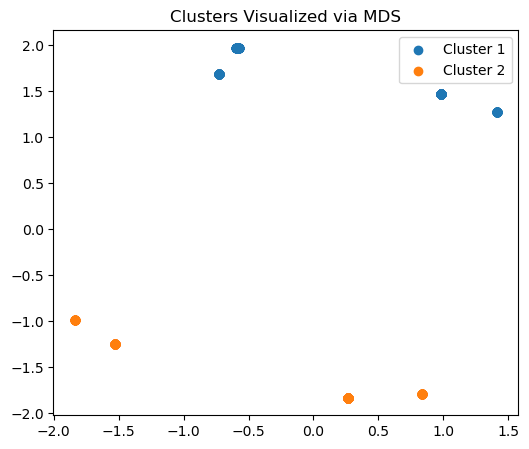

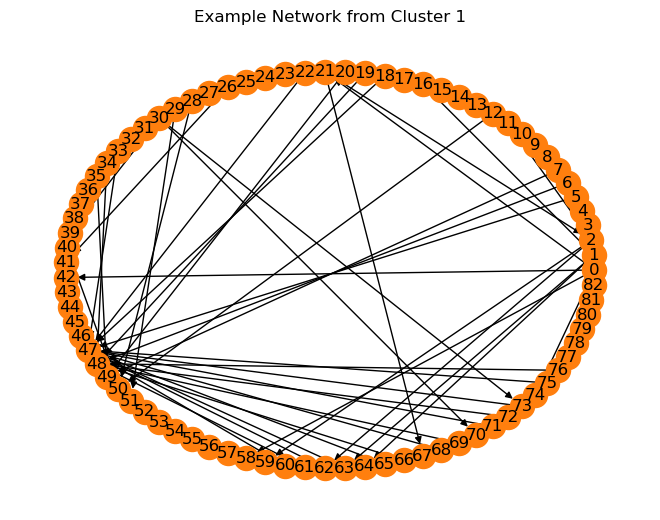

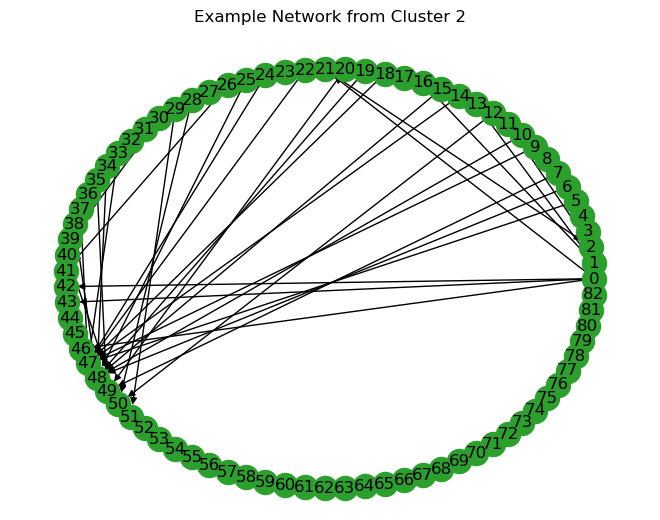

In [99]:
# Hierarchical clustering
Z = linkage(distance_matrix, method='ward')
labels = fcluster(Z, 2, criterion='maxclust')

# Visualize clusters with MDS
mds = MDS(dissimilarity='precomputed', random_state=12345)
coords = mds.fit_transform(distance_matrix)

plt.figure(figsize=(6, 5))
for cluster in np.unique(labels):
    idx = np.where(labels == cluster)
    plt.scatter(coords[idx, 0], coords[idx, 1], label=f'Cluster {cluster}')
plt.legend()
plt.title('Clusters Visualized via MDS')
plt.show()

# Plot example graphs from each cluster
for cluster in np.unique(labels):
    idx = np.where(labels == cluster)[0][0]
    G = networks[idx]
    plt.figure()
    pos = nx.circular_layout(G)
    nx.draw(G, pos, with_labels=True, node_color=f"C{cluster}")
    plt.title(f'Example Network from Cluster {cluster}')
    plt.show()

In [100]:
sd_cluster = pd.DataFrame(labels, index=model_list, columns=['sd_cluster'])
sd_cluster = sd_cluster['sd_cluster'].to_dict()

/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/seaborn/relational.py:313: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/seaborn/relational.py:313: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



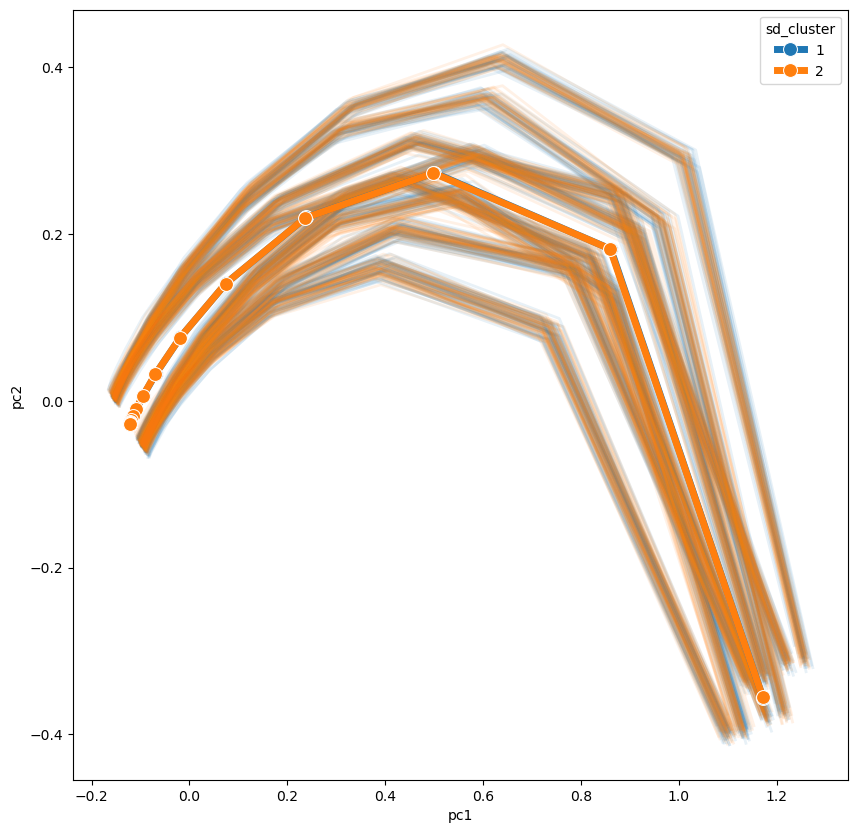

In [101]:
pca_df = model.trajectory.pca_df
pca_df['sd_cluster'] = pca_df['model_id'].map(sd_cluster)
fig_size = (10,10)

## Calculate the mean position
kmean_cluster = pca_df.groupby(['timepoint','sd_cluster'])[['pc1','pc2']].mean()

# Adjust figure size
plt.figure(figsize = fig_size)

## Plot with Seaborn
plot = sns.lineplot(data = pca_df, 
            x = 'pc1', y='pc2',
            hue = 'sd_cluster', units = 'model_id', estimator = None, lw=2, alpha = .1,
            sort = False, legend=False, palette='tab10')
plot2 = sns.lineplot(data = kmean_cluster, 
                    x = 'pc1',y='pc2',
                    hue = 'sd_cluster',
                    sort = False, marker = 'o', linewidth = 5, markersize = 10, palette='tab10')
plt.show()

/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.

/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/seaborn/matrix.py:530: ClusterWarning:

The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix

/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.

/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/seaborn/matrix.py:530: ClusterWarning:

The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



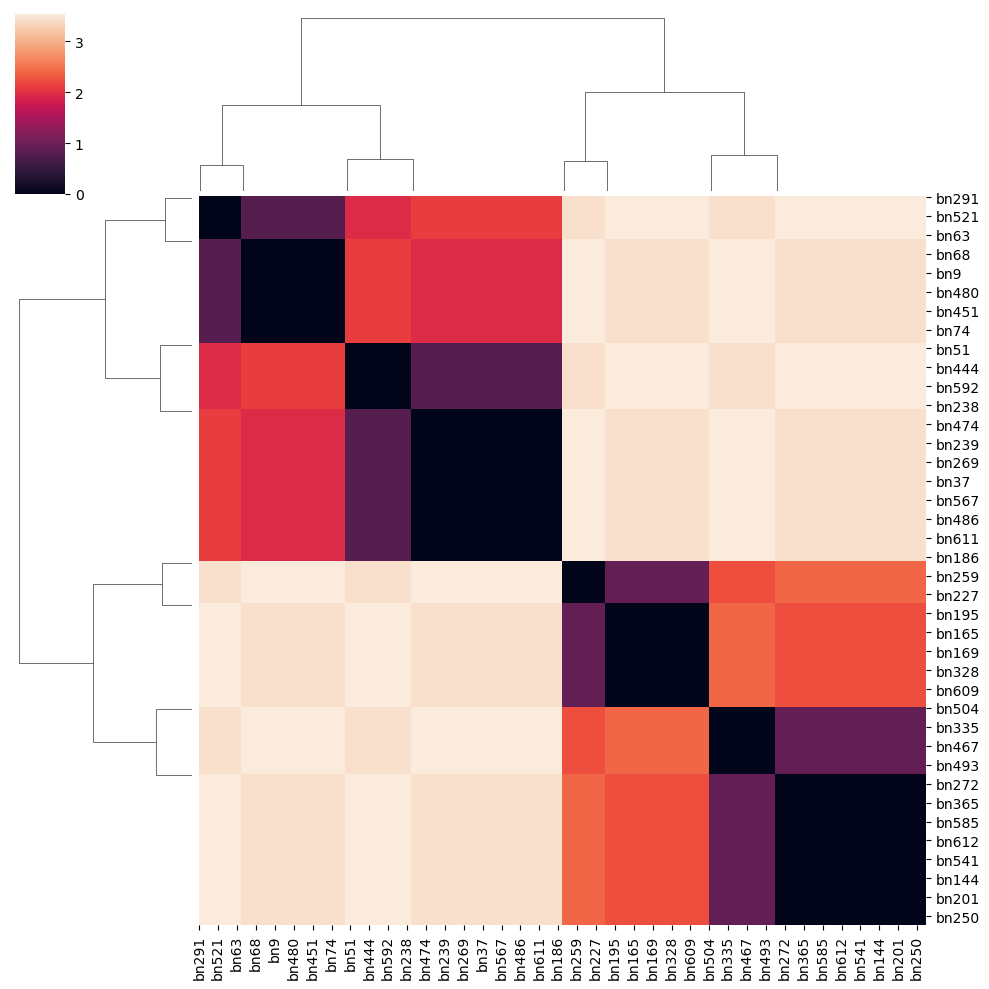

In [63]:
sns.clustermap(distance_matrix)

# Comparison with clustering from trajectory

In [104]:
os.chdir('/home/spankaew/Git/astrologics/')
import astrologics as le

In [105]:
model_path = '/home/spankaew/Git/astrologics/models/herault_hematopoiesis/'
model = le.LogicEnsemble(model_path, project_name = 'herault_hematopoiesis')
model.create_simulation()

Simulation object created


In [106]:
traj_dir = '/home/spankaew/Git/astrologics/models/herault_hematopoiesis' 
traj_data = pd.read_csv('/home/spankaew/Git/astrologics/models/herault_hematopoiesis_traj_df.csv', index_col= 0)
initial_state = traj_data.loc['iHSC']
initial_state = initial_state.dropna().to_dict()

In [127]:
node_list = model.simulation.simulation_df.columns.difference(['model_id', 'timepoint']).tolist()
initial_state = {node: 0.5 for node in node_list}
initial_state

{'Bclaf1': 0.5,
 'CDK46CycD': 0.5,
 'CIPKIP': 0.5,
 'Cebpa': 0.5,
 'Egr1': 0.5,
 'Fli1': 0.5,
 'Gata1': 0.5,
 'Gata2': 0.5,
 'Ikzf1': 0.5,
 'Junb': 0.5,
 'Klf1': 0.5,
 'Myc': 0.5,
 'Spi1': 0.5,
 'Tal1': 0.5,
 'Zfpm1': 0.5}

In [128]:
model.simulation.update_parameters(max_time = 30,thread_count = 15, sample_count = 3000)
model.simulation.run_simulation(initial_state = initial_state)

Start simulation


100%|██████████| 616/616 [02:10<00:00,  4.71it/s]


Simulation completed


Trajectory object created


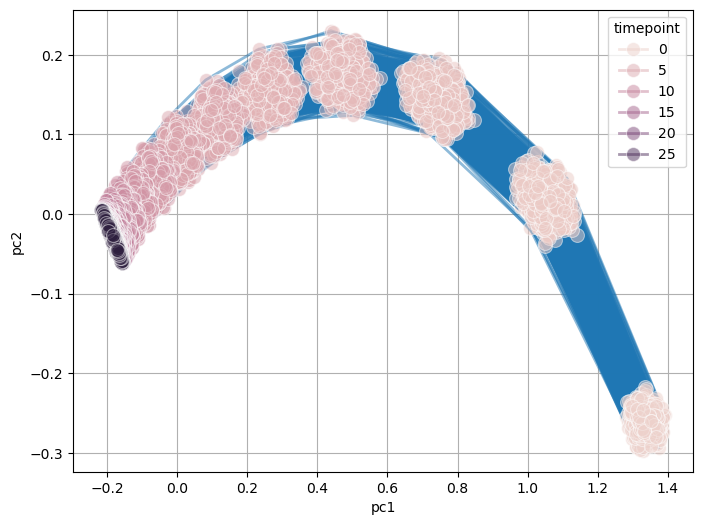

In [129]:
model.create_trajectory()
model.trajectory.pca_trajectory()
model.trajectory.plot_trajectory(color = 'timepoint', show_legend=True)

In [ ]:
model.trajectory.calculate_kmean_cluster(n_cluster = 2, metric='dtw')

DTW k-means


/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 44

0.080 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s


0.049 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s


0.045 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s


0.045 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s


0.045 --> 


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
/home/spankaew/Git/astrologics/astrologics/trajectory_clustering.py:222: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/home/spankaew/Git/astrologics/astrologics/trajectory_clustering.py:222: FutureWarning:

The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.



/home/spankaew/Git/astrologics/astrologics/trajectory_clustering.py:236: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/seaborn/relational.py:313: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/seaborn/relational.py:313: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



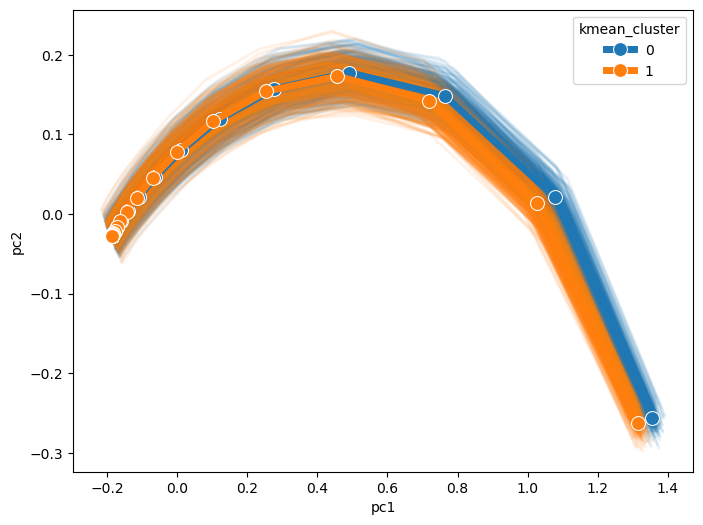

In [136]:
model.trajectory.plot_trajectory_cluster()

In [137]:
cluster_dict_df = pd.DataFrame.from_dict(model.trajectory.cluster_dict, orient='index')
cluster_dict_df.columns = ['traj_cluster']
model_clusters = pd.DataFrame(labels, index=model_list, columns=['sd_cluster'])
model_clusters = pd.concat([model_clusters, cluster_dict_df], axis=1, ignore_index = False)

In [138]:
model_clusters.to_csv('/home/spankaew/Git/astrologics/test_model_clusters.csv')

In [66]:
import plotly.graph_objects as go

# Prepare data for Sankey plot
source = []
target = []
value = []

# Create a mapping from cluster labels to indices
sd_cluster_labels = model_clusters['sd_cluster'].unique()
traj_cluster_labels = model_clusters['traj_cluster'].unique()

sd_cluster_map = {label: idx for idx, label in enumerate(sd_cluster_labels)}
traj_cluster_map = {label: idx + len(sd_cluster_labels) for idx, label in enumerate(traj_cluster_labels)}

# Populate source, target, and value lists
for _, row in model_clusters.iterrows():
    source.append(sd_cluster_map[row['sd_cluster']])
    target.append(traj_cluster_map[row['traj_cluster']])
    value.append(1)

# Define node labels
labels = [f'sd_cluster {label}' for label in sd_cluster_labels] + [f'traj_cluster {label}' for label in traj_cluster_labels]

# Create Sankey plot
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels
    ),
    link=dict(
        source=source,
        target=target,
        value=value
    )
)])

fig.update_layout(title_text="Sankey Diagram: sd_cluster vs traj_cluster", font_size=10)
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [139]:
summary_table = pd.crosstab(model_clusters['sd_cluster'], model_clusters['traj_cluster'])
summary_table

traj_cluster,0,1
sd_cluster,,
1,154,154
2,154,154
